In [1]:
import os
root_path = os.path.dirname(os.path.abspath('./'))
import sys
sys.path.append('./resources/')
sys.path.append('./modelling/')
sys.path.append(root_path+'/lobster_for_sdhawkes/py_scripts/')

In [2]:
import pickle
import time
import numpy as np
from scipy.ndimage.interpolation import shift as array_shift
import pandas as pd
from scipy import stats
import os
import bisect
import copy
import plot_tools
import matplotlib.pyplot as plt

In [3]:
import model as sd_hawkes_model
import lob_model
import computation
import simulation
import prepare_from_lobster as from_lobster
import goodness_of_fit
import mle_estimation as mle_estim
import impact_profile

In [4]:
import seaborn  # for good-looking plots
from IPython.display import set_matplotlib_formats  # set the figures format to svg
set_matplotlib_formats('svg')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

In [5]:
n_states=[3,5]
n_events = 4  # number of event types, $d_e$
n_levels = 2
upto_level = 2
time_start=np.random.uniform()
time_end=time_start+1.25*60*60
model = sd_hawkes_model.sd_hawkes(
    number_of_event_types=n_events,
    number_of_lob_levels=n_levels,
    list_of_n_states=n_states,
    volume_imbalance_upto_level=upto_level)
tot_n_states = model.state_enc.tot_n_states

In [6]:
# The transition probabilities $\phi$
phis = model.state_enc.generate_random_transition_prob(n_events=n_events).astype(np.float)

# The base rates $\nu$
nus = 0.001510*np.random.randint(low=1,high=6,size=n_events)

# The impact coefficients $\alpha$
alphas = np.random.uniform(0.0004,0.1875,size=(n_events, tot_n_states, n_events)).astype(np.float)


# The decay coefficients $\beta$
betas = np.random.uniform(1.12725,1.90,size=(n_events, tot_n_states, n_events)).astype(np.float)


# The Dirichlet parameters $\gamma$
gammas = np.random.uniform(low=1.5, high = 5.6,size=(tot_n_states,2*n_levels))



In [7]:
# symbol='INTC'
# date='2019-01-15'
# with open('./models/{}_{}_h_model'.format(symbol,date),'rb') as source:
#     h_model=pickle.load(source)
# with open('./models/{}_{}_orderBook_model'.format(symbol,date),'rb') as source:
#     ob_model=pickle.load(source)
# with open('./models/{}_{}_messageFile_model'.format(symbol,date),'rb') as source:
#     mf_model=pickle.load(source)    

In [8]:
# phis = lob_model.correct_null_transition_prob(h_model.transition_probabilities)
# nus=0.1*h_model.base_rates
# alphas=0.5*h_model.impact_coefficients
# betas=h_model.decay_coefficients
# gammas=h_model.dirichlet_param


In [9]:
model.set_hawkes_parameters(nus,alphas,betas)
model.set_dirichlet_parameters(gammas)
model.set_transition_probabilities(phis)
model.enforce_symmetry_in_transition_probabilities()

sd_hawkes: asymmetry in transition_probabilities = 36.905975414468614
sd_hawkes: new asymmetry in transition_probabilities = 3.076740298213702e-15


In [10]:
pre_times, pre_events, pre_states,pre_volumes = model.simulate(
    time_start, time_end,max_number_of_events=10000,add_initial_cond=True,
    store_results=True,report_full_volumes=False)
time_end_antefact=np.array(pre_times[-1],copy=True)

sd_hawkes: simulate: initial conditions have been acknowledged
I am adding initial conditions on the negative time axis
sd_hawkes_powerlaw_simulation.simulate: start of initialisation
   Number of levels in the order book: 2
   number_of_initial_events=61
sd_hawkes_powerlaw_simulation: simulate: labelled_times and count have been initialised.
sd_hawkes_powerlaw_simulation: simulate: intensities have been initialised.
  intensities at start: [0.12580082 0.1430586  0.12597046 0.10502219]
  intensity_overall at start: 0.4998520547668025
sd_hawkes_powerlaw_simulation.simulate: start of simulation
  time_start=0.22279836599310388,  time at start =0.22279836599310388
 Simulation terminates. time at end =4500.932813361475,  num_of_event=744
sd_hawkes_powerlaw_simulation: simulate. run_time=0.4 seconds


In [11]:
print(pre_times.shape)
print(pre_events.shape)
print(pre_volumes.shape)

(684,)
(684,)
(684, 4)


In [12]:
pre_intens_history= model.compute_history_of_intensities(
    pre_times,
    pre_events,
    pre_states)
pre_tilda_intens_history= model.compute_history_of_tilda_intensities(
    pre_times,
    pre_events,
    pre_states)

In [13]:
low_limit=0
up_limit=7200
idx=np.logical_and(pre_times<up_limit,pre_times>low_limit)
idx_history=np.logical_and(pre_intens_history[:,0]<up_limit,pre_intens_history[:,0]>low_limit)
# fig=plot_tools.plot_events_and_intensities(
#     1+pre_events[idx],pre_times[idx],pre_intens_history[idx_history,:],
#     save_fig=False
# )

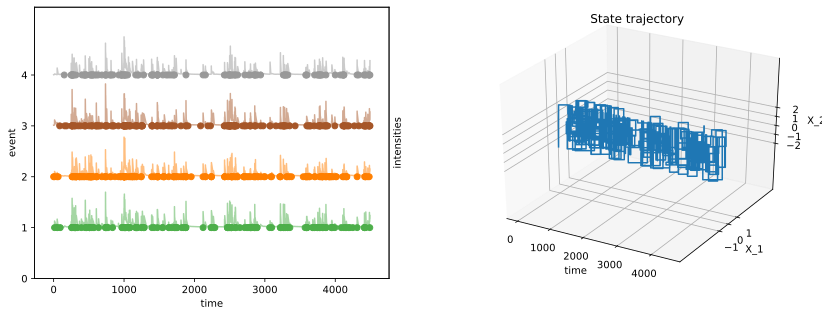

In [14]:
states_2D=model.produce_2Dstates(pre_states)
plot_tools.plot_events_and_states(pre_events+1,pre_times,pre_intens_history,states_2D,
                                plot=True,
                                save_fig=False,
                                  name='events_and_states_traject'
                               )

Compute residuals in parallel on 4 cpus
Parallel computation of residuals terminates. run_time=0.12579751014709473


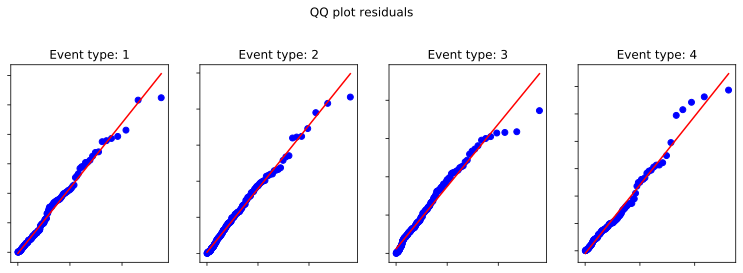

In [15]:
model.create_goodness_of_fit()
model.goodness_of_fit.qq_plot_residuals(index_of_first_event_type=1)

In [16]:
model.goodness_of_fit.ks_test_on_residuals()

Kolmogorov-Smirnov test to check that the residuals are iid with distribution Exp(1)
event type=0, ks_answer: KstestResult(statistic=0.08276145619014619, pvalue=0.1842566959107097)
event type=1, ks_answer: KstestResult(statistic=0.05988289562066196, pvalue=0.4886404946055525)
event type=2, ks_answer: KstestResult(statistic=0.06159419854892573, pvalue=0.45770357646455845)
event type=3, ks_answer: KstestResult(statistic=0.0663158616640343, pvalue=0.6103821180845891)


In [17]:
model.goodness_of_fit.ad_test_on_residuals()

Anderson-Darling test to check distribution of residuals
Null hypothesis is "expon" 
Significance levels: [15.  10.   5.   2.5  1. ]
Critical values: [0.919 1.074 1.336 1.6   1.95 ]
event type=0, ad_stat: 1.3428142779805228
event type=1, ad_stat: 0.7065602298383737
event type=2, ad_stat: 1.1010733149933571
event type=3, ad_stat: 0.6567735299450703


In [18]:
# print(claudio)

In [19]:
model.volume_enc.rejection_sampling.is_target_equal_to_proposal

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

In [20]:
model.volume_enc.prob_volimb_constraint

array([0.0230023 , 0.14351435, 0.3670367 , 0.09660966, 0.00160016,
       0.00260026, 0.39933993, 0.44744474, 0.55685569, 0.00810081,
       0.0270027 , 0.56025603, 0.59255926, 0.08550855, 0.04720472])

In [21]:
# %timeit simulation.sample_volumes(2,model.volume_enc.rejection_sampling.proposal_dir_param,model.volume_enc.rejection_sampling.difference_of_dir_params, model.volume_enc.rejection_sampling.inverse_bound,model.volume_enc.rejection_sampling.is_target_equal_to_proposal,model.state_enc.num_of_st2, model.volume_enc.volimb_limits, upto_lim = 5)

In [22]:
# %timeit simulation.sample_volumes(5,model.volume_enc.rejection_sampling.proposal_dir_param,model.volume_enc.rejection_sampling.difference_of_dir_params, model.volume_enc.rejection_sampling.inverse_bound,model.volume_enc.rejection_sampling.is_target_equal_to_proposal,model.state_enc.num_of_st2, model.volume_enc.volimb_limits, upto_lim = 5)

In [23]:
# model.volume_enc.rejection_sampling.inverse_bound

In [24]:
# print(claudio)

# Liquidation section


In [25]:
initial_condition_times=np.array(pre_times,copy=True)
initial_condition_events=np.array(pre_events,copy=True)
initial_condition_states=np.array(pre_states,copy=True)
initial_condition_volumes=np.array(pre_volumes,copy=True)

In [26]:
initial_inventory=10
liquidator_base_rate=np.amin(nus)
liquidation_strategy='fraction_of_bid_side' # constant_rate or fraction_of_bid_side
liquidator_control=0.2
time_start=np.array(time_end_antefact+3.0,dtype=np.float,copy=True)
time_end=np.array(time_start+2*60*60)

In [27]:
model.introduce_liquidator(initial_inventory=initial_inventory,
                                 time_start=time_start,
                                 liquidator_base_rate=liquidator_base_rate,
                                 liquidator_control=liquidator_control)
initial_condition_events+=1
time_liquidation_starts=model.liquidator.time_start
print(model.liquidator.initial_inventory)
print(model.liquidator.base_rate)
print(model.liquidator.control_type)

sd_hawkes.introduce_liquidator:
  type_of_liquid:with_the_market, without self excitation.
 new number of event types= 5
10.0
0.00302
fraction_of_inventory


In [28]:
liquidator_base_rate=0.10
model.configure_liquidator_param(
    initial_inventory=initial_inventory,
    liquidator_base_rate=liquidator_base_rate,
    type_of_liquid='constant_intensity',
    liquidator_control=liquidator_control)
print(model.liquidator.initial_inventory)
print(model.liquidator.base_rate)
print(model.liquidator.control_type)
print(np.linalg.norm(model.liquidator.imp_coef))

10.0
0.1
fraction_of_inventory
0.0


In [29]:
times, events, states, volumes, \
inventory, _=\
model.simulate_liquidation(
    time_end,
    initial_condition_events=initial_condition_events,
    initial_condition_states=initial_condition_states,
    initial_condition_times=initial_condition_times,
    initial_condition_volumes=initial_condition_volumes,
    verbose=True,
    report_history_of_intensities = False,
    store_results=True
)
print('\n')
print('times.shape={}'.format(times.shape))
print('events.shape={}'.format(events.shape))
print('states.shape={}'.format(states.shape))
print('inventory.shape={}'.format(inventory.shape))

sd_hawkes: simulate_liquidation. initial conditions have been acknowledged
simulate_liquidation. liquidator_control_type: fraction_of_inventory
  initial_invetory:10.0
   number_of_initial_events=684
initial state:9, last event:3
initialisation of run_time: -1582632059.9420903
sd_hawkes_powerlaw_simulation: simulate: labelled_times and count have been initialised.
 labelled_times.shape=(5,15,1000684), count.shape=(5,15)
sd_hawkes_powerlaw_simulation: simulate: intensities have been initialised.
  intensities at start: [0.1        0.07106923 0.06572477 0.07103812 0.0759839 ]
  intensity_overall at start: 0.3838160153072717
sd_hawkes_powerlaw_simulation.simulate: start of simulation
  time_start=4495.640969802876,  time at start =4495.640969802876
simulate_liquidation. At time 4501.119876331485, liquidator intervenes:
  previous state=[1 1], previous_volume=[0.57759288 0.09463603 0.13450059 0.1932705 ]
  quantity_to_liquidate=0.2, to_subtract=[0.09463603 0.10536397], quantity_liquidated=

simulate_liquidation. At time 4821.670630763925, liquidator intervenes:
  previous state=[1 3], previous_volume=[0.07982906 0.24537943 0.23966427 0.43512723]
  quantity_to_liquidate=0.2, to_subtract=[0.2 0. ], quantity_liquidated=0.2
  new_state=[1 2], new_volume=[0.12980135 0.04537943 0.38969198 0.43512723], new_tot_bid=0.48050666673757836.
simulate_liquidation. At time 4826.985882545875, liquidator intervenes:
  previous state=[1 0], previous_volume=[0.59116954 0.14444883 0.22288317 0.04149846]
  quantity_to_liquidate=0.2, to_subtract=[0.14444883 0.04149846], quantity_liquidated=0.18594728987641782
  new_state=[0 0], new_volume=[0.72620548 0.         0.27379452 0.        ], new_tot_bid=0.0.
simulate_liquidation. At time 4829.62558877609, liquidator intervenes:
  previous state=[0 0], previous_volume=[0.40778571 0.06528989 0.40138805 0.12553635]
  quantity_to_liquidate=0.2, to_subtract=[0.06528989 0.12553635], quantity_liquidated=0.19082624098324788
  new_state=[0 0], new_volume=[0.50

In [30]:
start_liquidation=time_liquidation_starts
end_liquidation=model.liquidator.termination_time
intens_history= model.compute_history_of_intensities(
    times,
    events,
    states,
    start_time_zero_event=start_liquidation,
    end_time_zero_event=end_liquidation,
    density_of_eval_points=10000,
)
print('intens_history.shape={}'.format(intens_history.shape))
idx=intens_history[:,1]>0
print(np.sum(idx))

intens_history.shape=(12158, 6)
770


In [31]:
plot_start_index=bisect.bisect_left(times,time_start)-5
plot_end_index=np.argmin(inventory)+30
# pd.Series(inventory[plot_start_index:plot_end_index]).plot()

In [32]:
# plot_tools.plot_liquidation(times,events,inventory,intens_history,
#                             plot_start_index,plot_end_index,
#                             save_fig=False)

In [33]:
df=model.state_enc.translate_labels(states)
price=np.sum(np.abs(df['st_1'].values))+100+0.85*np.cumsum(df['st_1'].values-1)
price=0.01*price

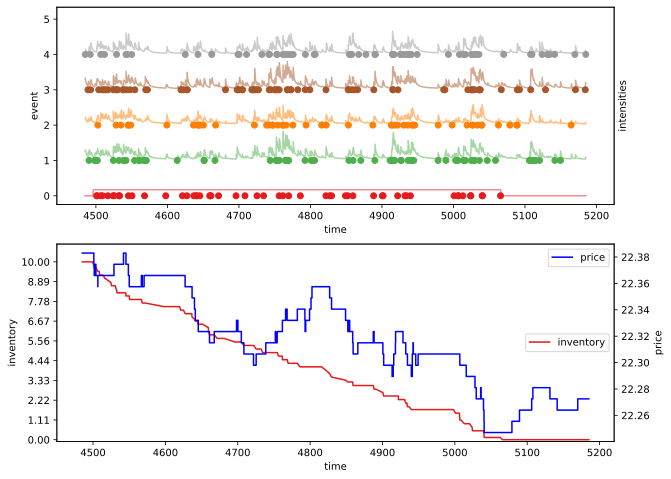

In [34]:
plot_tools.plot_liquidation_with_price(times,events,inventory,intens_history,price,
                            plot_start_index,plot_end_index,
                            save_fig=False,path='/home/claudio/Desktop/imperialMF_phdDay/pictures/',
                            name='plot_liquidation_n'          )

In [35]:
# plot_tools.plot_liquidator_only(times,events,inventory,intens_history,price,
#                             plot_start_index,plot_end_index,
#                             save_fig=False,path='/home/claudio/Desktop/imperialMF_phdDay/pictures/',
#                             name='plot_liquidator_4' )

In [36]:
# print(claudio)

# Impact profile a\` la Bacry-Muzy

In [37]:
bm_intensity, bm_profile=model.compute_bm_impact_profile(times,events,states,
                                  inventory,
                                  start_liquidation_time = time_liquidation_starts,
                                  density_of_eval_points=10000)

In [38]:
# plot_tools.plot_bm_impact_profile(bm_profile,
#                        bm_intensity,
#                        time_start=time_liquidation_starts,
#                        time_end=times[np.argmin(inventory)]+100,
#                        save_fig=False,
#                        path='/home/claudio/Desktop/imperialMF_phdDay/pictures/',
#                        name='bm_impact_profile_3'          )

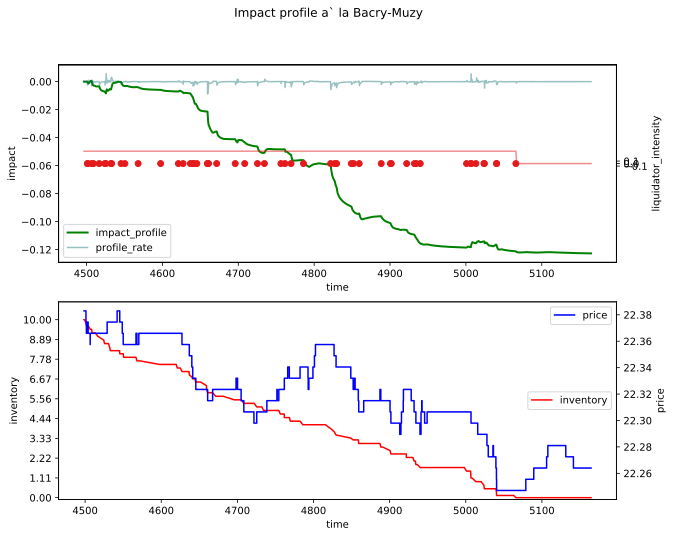

In [39]:
plot_tools.plot_bm_impact_profile_full_picture(bm_profile,
                       times,events,inventory,intens_history,price,
                       bm_intensity,
                       time_start=time_liquidation_starts,
                       time_end=times[np.argmin(inventory)]+100,
                       save_fig=False,
                       path='/home/claudio/Desktop/imperialMF_phdDay/pictures/',
                       name='bm_impact_profile_full_3'                         )

In [40]:
print(claudio)

NameError: name 'claudio' is not defined

In [ ]:
# model.set_transition_probabilities(phis_hat)
# model.set_hawkes_parameters(nus_hat, alphas_hat, betas_hat)
# model.set_dirichlet_parameters(gammas_hat)

# One-sided impact profile

In [ ]:
model.produce_impact_profile(num_init_guesses=4, maxiter=20)

In [ ]:
model.impact.reduced_weakly_defl_pp.create_goodness_of_fit()

In [ ]:
model.impact.reduced_weakly_defl_pp.goodness_of_fit.qq_plot_residuals(
    tot_event_types=1, title_per_event_type=0, fig_suptitle='QQ plot residuals of reduced_weakly_defl_pp')

In [ ]:
times=np.array(model.sampled_times,copy=True)
states=np.array(model.sampled_states,copy=True)
labelled_times = np.array(model.labelled_times,copy=True)
count = np.array(model.count, copy=True)
len_states=len(states)
eval_time=np.random.uniform(low=model.liquidator.time_start+10,
                            high=model.liquidator.termination_time,
                           )
print('eval_time={}'.format(eval_time))
nu_zero=model.base_rates[0]

t=np.random.uniform(low = 0.1, high = times[-100])
P_T_geq_t=impact_profile.evaluate_anti_cdf_execution_horizon(t,nu_zero,model.liquidator.num_orders)
print(t,P_T_geq_t)

In [ ]:
run_time=-time.time()
compensator=model.impact.evaluate_compensator_of_weakly_defl_pp(eval_time)
expectation=model.impact.reduced_weakly_defl_pp.compute_expectation(eval_time)
run_time+=time.time()
print('compesator={}, expectation={}'.format(compensator,expectation))
print('run_time={}'.format(run_time))

In [ ]:
run_time=-time.time()
res=model.impact.evaluate_impact_profile(eval_time)
run_time+=time.time()
print('run_time={}'.format(run_time))
print(res)

In [ ]:
T=np.random.uniform(low=model.sampled_times[10], high=model.sampled_times[150])
print('T={}'.format(T))
run_time=-time.time()
res=model.impact.compute_imp_profile_history(T,num_extra_eval_points=5)
run_time+=time.time()
print('run_time={}'.format(run_time))
print(res)

In [ ]:
plot_tools.plot_impact_profile(
    res,
    times,events,inventory,intens_history,price,
    time_start=model.liquidator.time_start,
    time_end=model.liquidator.termination_time,
    save_fig=False,
    path='/home/claudio/Desktop/imperialMF_phdDay/pictures/',
    name='onesided_impact_profile'
)

In [ ]:
print(claudio)

In [ ]:
p_prof=pd.Series(res[:,1],index=res[:,0])
p_prof.plot()

# Goodness of fit

In [ ]:
model.create_goodness_of_fit()

In [ ]:
model.goodness_of_fit.qq_plot_residuals()

# Simulation with power kernel

In [ ]:
number_of_states

In [ ]:
n_events = 4  
number_of_event_types= 4
number_of_states = tot_n_states
n_levels = 2
times=np.array([0.001],dtype=np.float)
init_times=np.atleast_1d(times)
events=np.array([0],dtype=np.int)
init_events=np.atleast_1d(events)
states = np.array([0],dtype=np.int)
init_states=np.atleast_1d(states)
volumes = np.ones((1,2*n_levels),dtype=np.float)
init_volumes = np.atleast_2d(volumes)
time_start = times[-1]+np.random.uniform(low=1,high=3)
time_end = time_start + 4*60*60
max_number_of_events = 7000
print('I will start the simulation')
times,events,states,volumes=\
lob_hs_power.launch_simulation(number_of_event_types,
                      number_of_states,
                      n_levels,
                      nus, alphas, betas, phis, gammas,
                      init_times, init_events, init_states,
                      init_volumes,
                      time_start,
                      time_end,
                      max_number_of_events,
                      add_initial_cond=False,
                      num_preconditions = 1,         
                      largest_negative_time = -100.0,
                      initialise_intensity_on_history = 1)
if events.shape[0]>=max_number_of_events:
    time_end = times[-1]
labelled_times, count = power_cython.distribute_times_per_event_state(
        number_of_event_types,number_of_states,
        times,events, states)    
print('Simulation terminated\n')

In [ ]:
g_fit = goodness_of_fit.good_fit(number_of_event_types,
                            number_of_states,
                            nus,
                            alphas,
                            betas,
                            phis,     
                            times,
                            events,
                            states)

In [ ]:
with open('../imperialMF_phdDay/goodfit_mle','rb') as source:
    g_fit=pickle.load(source)

In [ ]:
g_fit.ks_test_on_residuals()
# g_fit.ks_test_on_total_residuals()

In [ ]:
g_fit.ad_test_on_residuals()

In [ ]:
g_fit.qq_plot_residuals(save_fig=True,
                        path='/home/claudio/latex_files/imperialMF_phdDay/pictures/',
                        name='qq_plot_res_mle')

In [ ]:
g_fit.qq_plot_total_residuals()

In [ ]:
g_fit.qq_plot_omnibus()

# Section 3

In [ ]:
n_events=np.array(n_events,dtype=int)
tot_n_states=np.array(tot_n_states,dtype=int)
number_of_event_types=n_events
number_of_states=tot_n_states

In [ ]:
s=times[np.random.randint(1,len(times)//2)]+np.random.normal(loc=0,scale=10)
t=times[np.random.randint(len(times)-10,len(times)-1)]+np.random.normal(loc=0,scale=10)
u=np.random.uniform(low=t,high=np.amax(times)+10)
time_start = times[3]
time_end = times[-2]
run_time = -time.time()
labelled_times,count=power_cython.distribute_times_per_event_state(
            number_of_event_types,
            number_of_states,
            times,
            events,
            states) 
run_time+=time.time()
print('run_time={} seconds'.format(run_time))

In [ ]:
residuals=power_cython.compute_residuals(number_of_event_types,
                            number_of_states,
                            nus,
                            alphas,
                            betas,
                            times,
                            events,
                            states)

In [ ]:
g_fit = goodness_of_fit.good_fit(number_of_event_types,
                            number_of_states,
                            nus,
                            alphas,
                            betas,
                            times,
                            events,
                            states)

In [ ]:
# new_ev = 0
# new_state = 0
# arr_time= 130119992
# print(count[new_ev,new_state])
# print(labelled_times[new_ev,new_state,count[new_ev,new_state]-3:count[new_ev,new_state]])
# new_lt, new_count = power_cython.update_labelled_times(arr_time, new_ev, new_state,
#                                                        labelled_times,count)
# print(count[new_ev,new_state])
# print(new_count[new_ev,new_state])
# print(labelled_times[new_ev,new_state,count[new_ev,new_state]-3:count[new_ev,new_state]])
# print(new_lt[new_ev,new_state,new_count[new_ev,new_state]-3:new_count[new_ev,new_state]])

In [ ]:
run_time = -time.time()
intensity=power_cython.compute_intensities(t,
                               times,
                               events,
                               states,
                               nus,
                               alphas,
                               betas
                              )
run_time+=time.time()
sum_int=np.sum(intensity)
print('intensity =  \n {}'.format(intensity))
print('sum_int={}'.format(sum_int))
print('run_time={} seconds'.format(run_time))

In [ ]:
run_time = -time.time()
intensity=power_cython.compute_intensities_given_lt(t,
                             labelled_times,count,
                             nus,alphas,betas
                            )
run_time+=time.time()
sum_int=np.sum(intensity)
print('intensity =  \n {}'.format(intensity))
print('sum_int={}'.format(sum_int))
print('run_time={} seconds'.format(run_time))

In [ ]:
run_time = -time.time()
intensity=power_cython.compute_intensity(t,
                               times,
                               events,
                               states,
                               nus,
                               alphas,
                               betas
                              )
run_time+=time.time()
print('intensity =  \n {}'.format(intensity))
print('run_time={} seconds'.format(run_time))

In [ ]:
ESSE=np.zeros((number_of_event_types,number_of_states,number_of_event_types))
ESSE_one=np.zeros((number_of_event_types,number_of_states,number_of_event_types))
for e in range(n_events):
    run_time = -time.time()
    ESSE[:,:,e],ESSE_one[:,:,e]=\
    power_cython.compute_ESSE_partial_and_ESSE_one_partial(t, s,
                             alphas[:,:,e],
                             labelled_times,
                             count                 
                            )
    run_time+=time.time()
    print('event_type={}, run_time={} seconds'.format(e,run_time))
    

In [ ]:
ESSE_1=np.zeros((number_of_event_types,number_of_states,number_of_event_types))
ESSE_one_1=np.zeros((number_of_event_types,number_of_states,number_of_event_types))
for e in range(n_events):
    run_time = -time.time()
    ESSE_1[:,:,e],ESSE_one_1[:,:,e]=\
    power_cython.compute_ESSE_partial_and_ESSE_one_partial_plain(t, s,
                             alphas[:,:,e],
                             labelled_times,
                             count                 
                            )
    run_time+=time.time()
    print('event_type={}, run_time={} seconds'.format(e,run_time))
    

In [ ]:
np.all(ESSE==ESSE_1)

In [ ]:
ratios=alphas/(betas-1)
run_time = -time.time()
S=power_cython.compute_ESSE(t,s,betas,labelled_times)
S_3=power_cython.compute_ESSE_three(u,t,s,betas,labelled_times)
run_time+=time.time()
print('run_time={} seconds'.format(run_time))
print('|S|={}'.format(np.linalg.norm(S)))
print('|S_3|={}'.format(np.linalg.norm(S_3)))

In [ ]:
print(np.all(labelled_times>=-1))
print(time_start)

In [ ]:
for e in range(n_events):
    run_time = -time.time()
    l_plus, grad_base_rate, grad_imp_coef, grad_dec_coef=\
    power_cython.compute_l_plus_partial_and_gradient_partial(
        e,time_start,
        nus[e],
        alphas[:,:,e],
        betas[:,:,e],
        labelled_times,count)
    run_time+=time.time()
    print('event_type={}, run_time={} seconds'.format(e,run_time))
    print('l_plus={}'.format(l_plus))

In [ ]:
for e in range(n_events):
    run_time = -time.time()
    l_plus_1, grad_base_rate_1, grad_imp_coef_1, grad_dec_coef_1=\
    hp_nogil.compute_l_plus_partial_and_gradient_partial(
        e,time_start,
        nus[e],
        alphas[:,:,e],
        betas[:,:,e],
        labelled_times,count)
    run_time+=time.time()
    print('event_type={}, run_time={} seconds'.format(e,run_time))
    print('l_plus_1={}'.format(l_plus_1))

In [ ]:
print(l_plus)
print(l_plus_1)

In [ ]:

print(np.isclose(l_plus,l_plus_1))

In [ ]:
for e in range(n_events):
    run_time = -time.time()
    event_type=np.array(e,dtype=int)
    log_likelihood,gradient = power_cython.compute_event_loglikelihood_partial_and_gradient_partial(
        event_type,
        nus[e],
        alphas[:,:,e],
        betas[:,:,e],
        labelled_times,
        count,
        time_start,
        time_end)
    run_time+=time.time()
    print('events.shape={}, run_time={} seconds'.format(events.shape,run_time))
    print('event_type={},log_likelihood={}, but I am also computing gradients \n'
          .format(event_type,log_likelihood))

# Minimisation section

In [ ]:
from minimisation_alg import minimisation_procedure as min_proced

In [ ]:
maxiter=25
e=0
event_type=np.array(e,dtype=int)
minim=min_proced(labelled_times,
                 count,
                 time_start,
                 time_end,
                 n_events,
                 tot_n_states,
                 event_type,
                 learning_rate=0.05,
                 maxiter=maxiter
                )


In [ ]:
# init_guesses = 2*np.ones((1+2*n_events*tot_n_states,2),dtype=np.float)
init_guesses = 2*np.random.uniform(low=1,high=4,size=(1+2*n_events*tot_n_states,4))
list_initguesses = list(init_guesses.T)
run_time=-time.time()
minim.parallel_minimisation(list_initguesses,return_results=False)
run_time+=time.time()
print('\n')
print('run_time={} seconds'.format(run_time))

In [ ]:
x_min=minim.minimiser
print(x_min)

In [ ]:
history=minim.grad_descent_history
pd.Series(history[:]).plot()

In [ ]:
history

In [ ]:
events_intc=events.astype(np.intc)
states_intc=states.astype(np.intc)
tot_n_states=np.array(tot_n_states,dtype=np.intc)
n_events = np.array(n_events,dtype=np.intc)
run_time=-time.time()
phi_hat=mle_estim.estimate_transition_probabilities(n_events,tot_n_states,events_intc,states_intc)
run_time+=time.time()
print('\n')
print('run_time={} seconds'.format(run_time))

In [ ]:
run_time=-time.time()
base_rate,imp_coef,dec_coef=mle_estim.pre_estimate_ordinary_hawkes(1,n_events,
                             times,events,
                             time_start,time_end
                            )
run_time+=time.time()
print('\n')
print('run_time={} seconds'.format(run_time))

In [ ]:
run_time=-time.time()
base_rate=mle_estim.pre_guess_base_rate(
    2,
    times,
    events,
    time_start,
    time_end)
run_time+=time.time()
print('\n')
print('run_time={} seconds'.format(run_time))
print('initial guess base_rate = {}'.format(base_rate))

In [ ]:
from scipy.stats import dirichlet as scipy_dirichlet

In [ ]:
dir_param=np.array([1., 1.2, 1.3, 3.0])
n_levels=2
constraint=np.array([-0.2,+0.32],dtype=np.float)
computation.compute_probability_of_volimb_constraint(n_levels, constraint,dir_param,N_samples=99999)

In [ ]:
model.state_enc.volimb_limits

In [ ]:
alpha=np.array(model.dirichlet_param,copy=True)
masses= computation.produce_dirichlet_masses(alpha)
print(alpha.shape,masses.shape)

In [ ]:
masses

In [ ]:
alpha

In [ ]:
import sympy as sp

In [ ]:
g_1, g_2, g_3=sp.symbols('g_1 g_2 g_3')
x,y,z=sp.symbols('x y z')
system=[g_1*x + y +z -1,x+g_2*y+z-1,x+y+g_3*z-1]
sp.linsolve(system,(x,y,z))

In [ ]:
def compute_maximiser_unnormalised_beta_density( exponents):
    N = len(exponents)-1
    idx_diag = np.diag_indices(N)
    A = np.ones((N,N),dtype=np.float)
    diag_entries = (exponents[:N] + exponents[N])/exponents[:N]
    print(diag_entries)
    A[idx_diag] = diag_entries
    print(A)
    b = np.ones(N,dtype=np.float)
    result = np.zeros(N+1,dtype=np.float)
    result[:N] = np.linalg.solve(A,b)
    result[N]= 1- np.sum(result[:N])
    return result 

In [ ]:
alpha = np.random.uniform(low=0.01, high=2, size=4)
print('alpha={}'.format(alpha))
mode = (alpha - 1)/(np.sum(alpha)-len(alpha))
maximiser = computation.compute_maximiser_unnormalised_beta_density(-1+alpha)

In [ ]:
mode

In [ ]:
maximiser

In [ ]:
np.sum(mode)

In [ ]:
np.sum(maximiser)

In [ ]:
scipy_dirichlet.pdf(mode,alpha)

In [ ]:
scipy_dirichlet.pdf(maximiser,alpha)

In [ ]:
model.state_enc.df_state_enc

In [ ]:
model.state_enc.volimb_limits

In [ ]:
arr= np.random.randint(low=0, high=10, size = 54)
arr

In [ ]:
arr[1:20:2]

In [ ]:
arr[1:55:2]

In [ ]:
t_st= np.array([2,0],dtype=int)
table=model.state_enc.arr_state_enc
print(t_st)
print(table)

In [ ]:
idx=np.sum(table[:,1:]==t_st,axis=1)==2
table[idx,0]

In [ ]:
table[idx,0][0]

In [ ]:
table[0,1]

In [ ]:

idx

In [ ]:
A[idx]

In [ ]:
module.volume_